In [32]:
import gymnasium as gym
import pygame
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [33]:
import agent_class as agent


# Создание среды

In [34]:
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env, reward_params):
        super().__init__(env)
        self.reward_params = reward_params

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        reward = self.reward_action_dependent(observation, reward, terminated, truncated, info)
        return observation, reward, terminated, truncated, info

    def custom_reward(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation
        distance_reward = -abs(x) * self.reward_params['distance_penalty']
        angle_penalty = -abs(angle) * self.reward_params['angle_penalty']
        velocity_reward = -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty']
        reward += distance_reward + angle_penalty + velocity_reward
        if terminated and reward > 0:
            reward += self.reward_params['landing_bonus']
        return reward
    
    def reward_survive_and_be_accurate(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation
        distance_reward = -abs(x) * self.reward_params['distance_penalty']
        angle_penalty = -abs(angle) * self.reward_params['angle_penalty']
        velocity_penalty = -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty']

        reward += distance_reward + angle_penalty + velocity_penalty

        if terminated:
            if reward > 0:
                reward += self.reward_params['landing_bonus']
            else:
                reward -= self.reward_params['landing_bonus']
        elif truncated:
            reward -= self.reward_params['landing_bonus'] / 2
        else:
            reward += 0.1
        return reward
    
    def reward_fast_and_accurate(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation
        distance_reward = -abs(x) ** 2 * self.reward_params['distance_penalty']  # Квадратичный штраф за расстояние
        angle_penalty = -abs(angle) ** 2 * self.reward_params['angle_penalty']  # Квадратичный штраф за угол
        velocity_reward = -(abs(vx) + abs(vy)) ** 2 * self.reward_params['velocity_penalty'] # Квадратичный штраф за скорость

        reward += distance_reward + angle_penalty + velocity_reward

        if terminated and reward > 0:
            reward += self.reward_params['landing_bonus'] * 2  # Большой бонус за успешную посадку
        elif terminated:
            reward -= self.reward_params['landing_bonus'] * 2 # Большой штраф за падение
        elif truncated:
            reward -= self.reward_params['landing_bonus']

        return reward
    
    def reward_based_on_height(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation

        # Штраф за расстояние
        distance_reward = -abs(x) * self.reward_params['distance_penalty']

        # Угол
        angle_penalty = -abs(angle) * self.reward_params['angle_penalty']

        # Скорость
        velocity_penalty = -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty']

        reward += distance_reward + angle_penalty + velocity_penalty


        # Поощряем снижение скорости при приближении к земле
        if y < 50:  # Например, на высоте меньше 50 метров
            reward += -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty'] * 2 # Удваиваем штраф за скорость,чтобы замедлиться

        if terminated and reward > 0:
            reward += self.reward_params['landing_bonus']
        elif terminated:
            reward -= self.reward_params['landing_bonus']

        elif truncated:
            reward -= self.reward_params['landing_bonus'] / 2

        return reward
    
    def reward_sparse(self, observation, reward, terminated, truncated, info):
        if terminated and reward > 0:
            reward = self.reward_params['landing_bonus']  # Только бонус за успешную посадку
        elif terminated:
            reward = -self.reward_params['landing_bonus'] # Штраф за падение
        elif truncated:
            reward = -self.reward_params['landing_bonus'] / 2
        else:
            reward = -0.1 #небольшой штраф за каждый шаг

        return reward
    
    def reward_action_dependent(self, observation, reward, terminated, truncated, info):
        x, y, vx, vy, angle, _, _, _ = observation

        distance_reward = -abs(x) * self.reward_params['distance_penalty']
        angle_penalty = -abs(angle) * self.reward_params['angle_penalty']
        velocity_penalty = -(abs(vx) + abs(vy)) * self.reward_params['velocity_penalty']
        reward += distance_reward + angle_penalty + velocity_penalty

        try:
            action = info['action']  # Предполагаем, что 'action' есть в info
            # Пример: Штрафуем за слишком большую тягу (предполагаем, что action - это значение тяги)
            if abs(action) > 0.8:
                reward -= 0.05 # Штраф

        except KeyError:
            print("Предупреждение: Информация о действии отсутствует в 'info'.")

        if terminated and reward > 0:
            reward += self.reward_params['landing_bonus']
        elif terminated:
            reward -= self.reward_params['landing_bonus']
        elif truncated:
            reward -= self.reward_params['landing_bonus'] / 2

        return reward

reward_params = {
    'distance_penalty': 0.1,
    'angle_penalty': 0.1,
    'velocity_penalty': 0.01,
    'landing_bonus': 100.0
}

env = gym.make('LunarLander-v3')
env = CustomRewardWrapper(env, reward_params)  # Оборачиваем среду

N_actions = env.action_space.n
observation, info = env.reset()
N_state = len(observation)

print('dimension of state space =',N_state)
print('number of actions =',N_actions)

env = gym.make('LunarLander-v3')
env = CustomRewardWrapper(env, reward_params)  # Оборачиваем среду и здесь!
print('dimension of state space =',N_state)
print('number of actions =',N_actions) #

dimension of state space = 8
number of actions = 4
dimension of state space = 8
number of actions = 4


In [35]:
parameters = {'N_state':N_state, 'N_actions':N_actions}
my_agent = agent.dqn(parameters=parameters)


# Train agent

In [ ]:
training_results = my_agent.train(environment=env,
                                verbose=True)


| episode | return          | minimal return      | mean return        |
|         | (this episode)  | (last 20 episodes)  | (last 20 episodes) |
|-----------------------------------------------------------------------
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
Предупреждение: Информация о действии отсутствует в 'info'.
П

In [ ]:
training_results.keys()

dict_keys(['episode_durations', 'epsiode_returns', 'n_training_epochs', 'n_steps_simulated', 'training_completed'])

# Отображение обучения агента

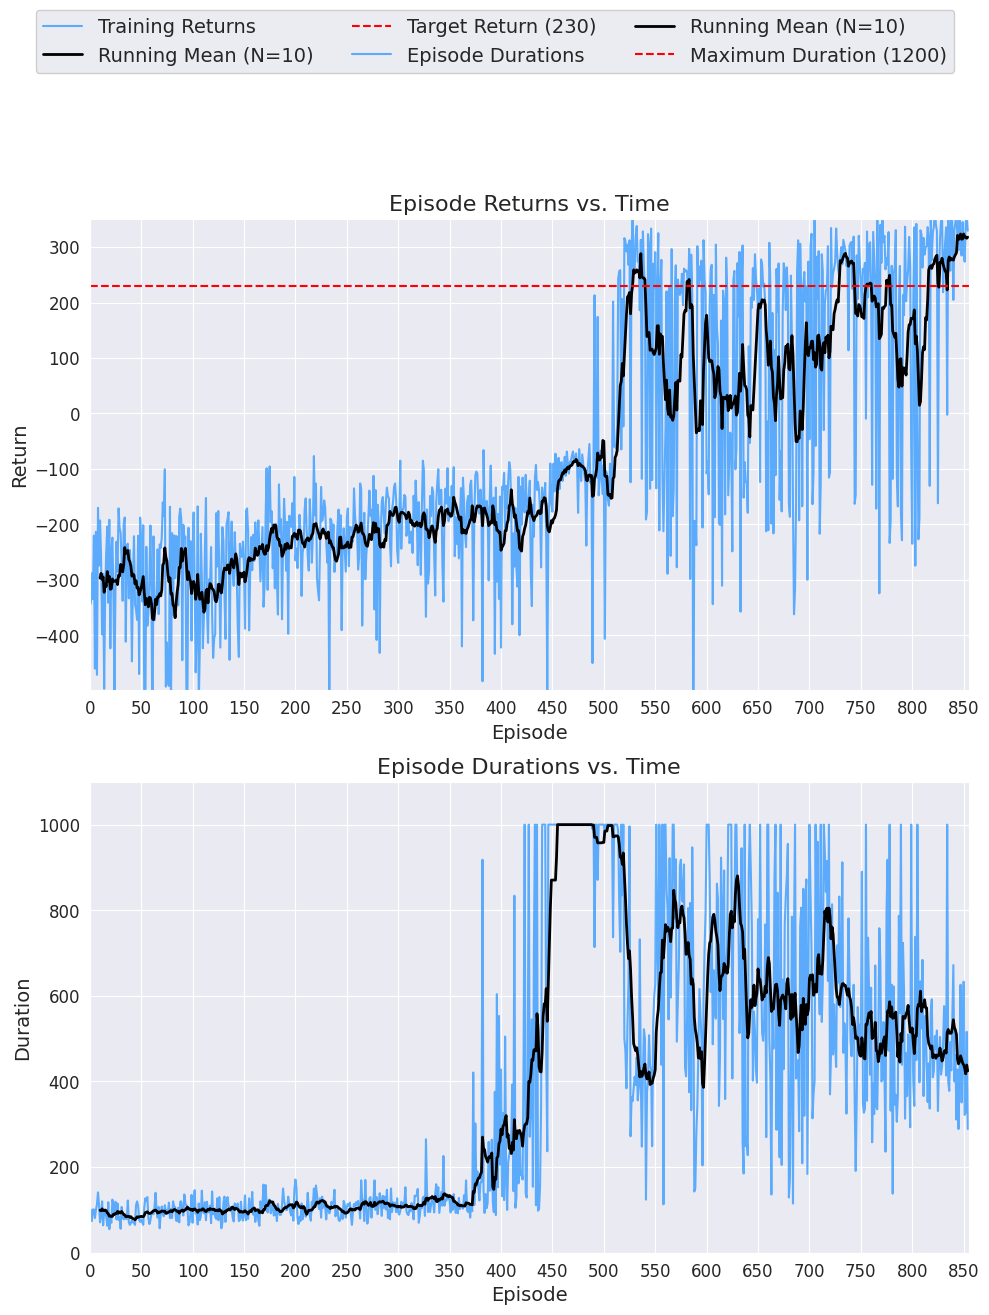

In [ ]:
import matplotlib.ticker as mticker 
import seaborn as sns 
N = 10  #Window size for rolling window  (originally set outside of the function, so can use a global constant)

def running_mean(x, N=20):
    """Calculates the running mean of a series x with window size N."""
    x_out = np.zeros(len(x) - N + 1, dtype=float)  #Correct the length of output to account for window size
    for i in range(len(x) - N + 1): #Correct indexing error
        x_out[i] = np.mean(x[i:i+N]) #Adjust to N instead of N+1
    return x_out

def plot_returns_and_durations(training_results, filename=None):
    """Plots returns and durations during training with running means."""

    sns.set_style("darkgrid")  # Use seaborn for better plot aesthetics
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # Increase figure size
    fig.subplots_adjust(hspace=0.1) #Reduce spacing
    

    # --- Plot Returns ---
    ax = axes[0]
    x = training_results['epsiode_returns']
    t = np.arange(1, len(x) + 1)

    ax.plot(t, x, label='Training Returns', color='dodgerblue', alpha=0.7)  # Slightly transparent for better visibility

    x_mean = running_mean(x, N=N)
    t_mean = np.arange(N, len(x) + 1) #Starting Point of Moving Average

    ax.plot(t_mean, x_mean, color='black', label=f'Running Mean (N={N})', linewidth=2) #More prominent running mean

    ax.axhline(230, ls='--', color='red', label='Target Return (230)')
    
    ax.set_ylim(-499, 350)
    #ax.set_xticks([])  # Remove x-ticks for cleaner look
    ax.set_xlim(0, len(x)+1)
    ax.set_xlabel('Episode', fontsize=14)
    ax.set_ylabel('Return', fontsize=14)
    ax.set_title('Episode Returns vs. Time', fontsize=16)  # Informative title
    ax.tick_params(axis='both', which='major', labelsize=12) #Adjust tick font size
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=50))   # Set ticks every 50 episodes

    # --- Plot Durations ---
    ax = axes[1]
    x = training_results['episode_durations']
    t = np.arange(1, len(x) + 1)

    ax.plot(t, x, label='Episode Durations', color='dodgerblue', alpha=0.7)

    x_mean = running_mean(x, N=N)
    t_mean = np.arange(N, len(x) + 1) #Starting Point of Moving Average

    ax.plot(t_mean, x_mean, color='black', label=f'Running Mean (N={N})', linewidth=2) #More prominent running mean


    ax.axhline(1200, ls='--', color='red', label='Maximum Duration (1200)') #Informative label
    ax.set_ylim(0, 1100)
    ax.set_xlim(0, len(x)+1)
    ax.set_xlabel('Episode', fontsize=14)
    ax.set_ylabel('Duration', fontsize=14)
    ax.set_title('Episode Durations vs. Time', fontsize=16) #Informative title
    ax.tick_params(axis='both', which='major', labelsize=12) #Adjust tick font size
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=50))   # Set ticks every 50 episodes



    # --- Legend ---
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, framealpha=0.95, fontsize=14) #Centralized Legend

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
    plt.show()


    if filename:
        fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)

# Example usage
plot_returns_and_durations(training_results=training_results, filename='training_plot.png')

# Создание видео используя обученного агента




We also create a video file containing 20 games played by the agent